In [1]:
! ls 'images'

sedona_left_01.png  sedona_right_01.png


## imports

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## tests

In [3]:
left=cv2.imread('images/sedona_left_01.png')
right=cv2.imread('images/sedona_right_01.png')
left=cv2.resize(left,(400,400))
right=cv2.resize(right,(400,400))
print(left.shape,right.shape)

(400, 400, 3) (400, 400, 3)


In [4]:
descriptor = cv2.xfeatures2d.SIFT_create()


In [5]:
gray_left = cv2.cvtColor(left,cv2.COLOR_BGR2GRAY)
gray_right=cv2.cvtColor(right,cv2.COLOR_BGR2GRAY)


In [6]:
ratio=0.75;min_match=10

In [7]:
(kps_left, features_left) = descriptor.detectAndCompute(gray_left, None)
(kps_right, features_right) = descriptor.detectAndCompute(gray_right, None)
# bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# matches = bf.match(features_left,features_right)
matcher = cv2.BFMatcher()
raw_matches = matcher.knnMatch(features_left, features_right, k=2)
good_points = []
good_matches=[]
for m1, m2 in raw_matches:
    if m1.distance < ratio * m2.distance:
        good_points.append((m1.trainIdx, m1.queryIdx))
        good_matches.append([m1])

if len(good_points) > min_match:
    image1_kp = np.float32(
        [kps_left[i].pt for (_, i) in good_points])
    image2_kp = np.float32(
        [kps_right[i].pt for (i, _) in good_points])
    H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)
    
result = cv2.warpPerspective(right, H,(right.shape[1] + left.shape[1], right.shape[0]))
result[0:left.shape[0], 0:left.shape[1]] = left  

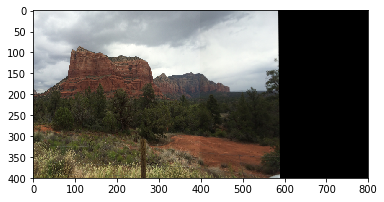

In [8]:
plt.imshow(result[:,:,::-1])

In [9]:
cv2.imwrite("stitched1.png",result)

True

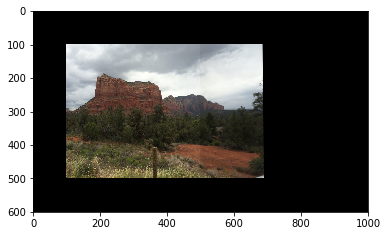

In [10]:
result_border= cv2.copyMakeBorder(result, 100, 100, 100, 100,cv2.BORDER_CONSTANT, (0, 0, 0))
plt.imshow(result_border[:,:,::-1])

False

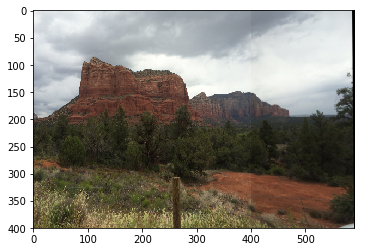

In [11]:
gray = cv2.cvtColor(result_border, cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
# plt.imshow(thresh,cmap='gray')
image, contours,hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
(x, y, w, h) = cv2.boundingRect(contours[0])

result_border_new= result_border[y:y + h, x:x + w]
plt.imshow(result_border_new[:,:,::-1])
cv2.imwrite('images/output/stitched_cropped.png',result_border_new)

## opencv createstitcher

In [84]:
stitcher = cv2.createStitcher()
(status, result2) = stitcher.stitch([left,right])
print(status)
cv2.imwrite("stitcher_result.png",result2)

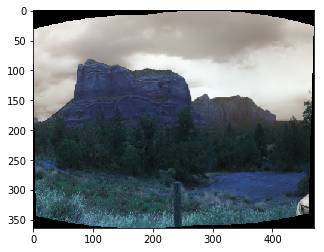

In [13]:
plt.imshow(result2)

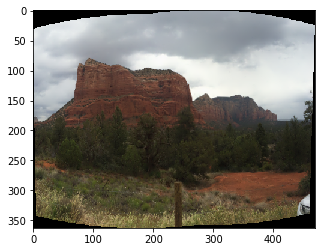

In [14]:
result2_border= cv2.copyMakeBorder(result2, 100, 100, 100, 100,cv2.BORDER_CONSTANT, (0, 0, 0))
# plt.imshow(result2_border[:,:,::-1])
gray2 = cv2.cvtColor(result2_border, cv2.COLOR_BGR2GRAY)
ret,thresh2 = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY)
# plt.imshow(thresh,cmap='gray')
image, contours,hierarchy = cv2.findContours(thresh2,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
(x, y, w, h) = cv2.boundingRect(contours[0])

result2_border_new= result2_border[y:y + h, x:x + w]
plt.imshow(result2_border_new[:,:,::-1])

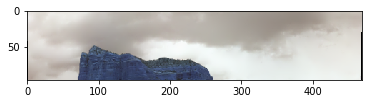

In [15]:
(status, result2) = stitcher.stitch([left,right])

_, thresh = cv2.threshold(cv2.cvtColor(result2, cv2.COLOR_BGR2GRAY), 1, 255, cv2.THRESH_BINARY)
# plt.imshow(thresh)
upper, lower = [-1, -1]

black_pixel_num_threshold = result2.shape[1]//100

for y in range(thresh.shape[0]):
    if len(np.where(thresh[y] == 0)[0]) < black_pixel_num_threshold:
        upper = y
        break

for y in range(thresh.shape[0]-1, 0, -1):
    if len(np.where(thresh[y] == 0)[0]) < black_pixel_num_threshold:
        lower = y
        break

plt.imshow(result2[upper:lower, :])

In [16]:
# (status, stitched) = stitcher.stitch([left,right])

# if status == 0:
# # check to see if we supposed to crop out the largest rectangular
# # region from the stitched image
#     # create a 10 pixel border surrounding the stitched image
#     print("[INFO] cropping...")
#     stitched = cv2.copyMakeBorder(stitched, 10, 10, 10, 10,
#         cv2.BORDER_CONSTANT, (0, 0, 0))

#     # convert the stitched image to grayscale and threshold it
#     # such that all pixels greater than zero are set to 255
#     # (foreground) while all others remain 0 (background)
#     gray = cv2.cvtColor(stitched, cv2.COLOR_BGR2GRAY)
#     thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

#     # find all external contours in the threshold image then find
#     # the *largest* contour which will be the contour/outline of
#     # the stitched image
#     cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
#         cv2.CHAIN_APPROX_SIMPLE)
# #     cnts = imutils.grab_contours(cnts)
# #     c = max(cnts, key=cv2.contourArea)
#     c=cnts[0]
#     # allocate memory for the mask which will contain the
#     # rectangular bounding box of the stitched image region
#     mask = np.zeros(thresh.shape, dtype="uint8")
#     (x, y, w, h) = cv2.boundingRect(c)
#     cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

#     # create two copies of the mask: one to serve as our actual
#     # minimum rectangular region and another to serve as a counter
#     # for how many pixels need to be removed to form the minimum
#     # rectangular region
#     minRect = mask.copy()
#     sub = mask.copy()

#     # keep looping until there are no non-zero pixels left in the
#     # subtracted image
#     while cv2.countNonZero(sub) > 0:
#         # erode the minimum rectangular mask and then subtract
#         # the thresholded image from the minimum rectangular mask
#         # so we can count if there are any non-zero pixels left
#         minRect = cv2.erode(minRect, None)
#         sub = cv2.subtract(minRect, thresh)

#     # find contours in the minimum rectangular mask and then
#     # extract the bounding box (x, y)-coordinates
#     cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL,
#         cv2.CHAIN_APPROX_SIMPLE)
# #     cnts = imutils.grab_contours(cnts)
# #     c = max(cnts, key=cv2.contourArea)
#     c=cnts[0]
#     (x, y, w, h) = cv2.boundingRect(c)

#     # use the bounding box coordinates to extract the our final
#     # stitched image
#     stitched = stitched[y:y + h, x:x + w]

# # write the output stitched image to disk
#     cv2.imwrite("output"+".png", stitched)

In [17]:
# result = cv2.copyMakeBorder(result, 10, 10, 10, 10,
#     cv2.BORDER_CONSTANT, (0, 0, 0))

# # convert the stitched image to grayscale and threshold it
# # such that all pixels greater than zero are set to 255
# # (foreground) while all others remain 0 (background)
# gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
# thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# # find all external contours in the threshold image then find
# # the *largest* contour which will be the contour/outline of
# # the stitched image
# cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
#     cv2.CHAIN_APPROX_SIMPLE)
# #     cnts = imutils.grab_contours(cnts)
# #     c = max(cnts, key=cv2.contourArea)
# c=cnts[0]
# # allocate memory for the mask which will contain the
# # rectangular bounding box of the stitched image region
# mask = np.zeros(thresh.shape, dtype="uint8")
# (x, y, w, h) = cv2.boundingRect(c)
# cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

# # create two copies of the mask: one to serve as our actual
# # minimum rectangular region and another to serve as a counter
# # for how many pixels need to be removed to form the minimum
# # rectangular region
# minRect = mask.copy()
# sub = mask.copy()

# # keep looping until there are no non-zero pixels left in the
# # subtracted image
# while cv2.countNonZero(sub) > 0:
#     # erode the minimum rectangular mask and then subtract
#     # the thresholded image from the minimum rectangular mask
#     # so we can count if there are any non-zero pixels left
#     minRect = cv2.erode(minRect, None)
#     sub = cv2.subtract(minRect, thresh)

# # find contours in the minimum rectangular mask and then
# # extract the bounding box (x, y)-coordinates
# cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL,
#     cv2.CHAIN_APPROX_SIMPLE)
# #     cnts = imutils.grab_contours(cnts)
# #     c = max(cnts, key=cv2.contourArea)
# c=cnts[0]
# (x, y, w, h) = cv2.boundingRect(c)

# # use the bounding box coordinates to extract the our final
# # stitched image
# result= result[y:y + h, x:x + w]
# plt.imshow(result[:,:,::-1])

## one function:

In [23]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

ratio=0.4;min_match=5
input_folder='beach'
output_folder=input_folder+'_output'
def create_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
# def read_images(folder):
#     images=[cv2.imread(os.path.join(os.getcwd(),folder,image)) for image in os.listdir(folder)]
#     return images
left= cv2.imread(input_folder+'/left.jpg')
right= cv2.imread(input_folder+'/right.jpg')
left=cv2.resize(left,(400,400))
right=cv2.resize(right,(400,400))
def crop(result):
    #reference -- pyimagesearch.com
    result = cv2.copyMakeBorder(result, 10, 10, 10, 10,
    cv2.BORDER_CONSTANT, (0, 0, 0))
    gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    c=cnts[0]
    mask = np.zeros(thresh.shape, dtype="uint8")
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)
    minRect = mask.copy()
    sub = mask.copy()


    while cv2.countNonZero(sub) > 0:

        minRect = cv2.erode(minRect, None)
        sub = cv2.subtract(minRect, thresh)


    cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)

    c=cnts[0]
    (x, y, w, h) = cv2.boundingRect(c)


    result= result[y:y + h, x:x + w]
    return result

    
    
def stitch(left,right,output_folder,use_opencv):
    create_folder(output_folder)
    descriptor = cv2.xfeatures2d.SIFT_create()

    print(left.shape)
    print(right.shape)
    if not use_opencv:
        print('tests')
        gray_left = cv2.cvtColor(left,cv2.COLOR_BGR2GRAY)
        gray_right=cv2.cvtColor(right,cv2.COLOR_BGR2GRAY)
        (kps_left, features_left) = descriptor.detectAndCompute(gray_left, None)
        (kps_right, features_right) = descriptor.detectAndCompute(gray_right, None)
        # bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
        # matches = bf.match(features_left,features_right)
        matcher = cv2.BFMatcher()
        raw_matches = matcher.knnMatch(features_left, features_right, k=2)
        good_points = []
        good_matches=[]
        for m1, m2 in raw_matches:
            if m1.distance < ratio * m2.distance:
                good_points.append((m1.trainIdx, m1.queryIdx))
                good_matches.append([m1])

        if len(good_points) > min_match:
            image1_kp = np.float32(
                [kps_left[i].pt for (_, i) in good_points])
            image2_kp = np.float32(
                [kps_right[i].pt for (i, _) in good_points])
            H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)

        result = cv2.warpPerspective(right, H,(right.shape[1] + left.shape[1], right.shape[0]))
        result[0:left.shape[0], 0:left.shape[1]] = left 
        print(result.shape)
        cv2.imwrite(os.path.join(output_folder,'uncropped.png'),result)
#         plt.imshow(result)
        cropped=crop(result)
        cv2.imwrite(os.path.join(output_folder,'cropped.png'),cropped)
#         plt.imshow(cropped)

    else:
        stitcher=cv2.createStitcher()
        (status, stitched) = stitcher.stitch([left,right])
        if status==0:
            cv2.imwrite(os.path.join(output_folder,'opencv_stitcher_uncropped.png'),stitched)
            cropped=crop(stitched)
            cv2.imwrite(os.path.join(output_folder,'opencv_stitcher_cropped.png'),cropped)
                
                
                
            
        
        
        
            

In [24]:
stitch(left,right,output_folder,False)

(400, 400, 3)
(400, 400, 3)
tests
(400, 800, 3)


### for video

In [49]:
input_folder='images_video'
output_folder=input_folder+'_output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [79]:
def crop(result):
    #reference -- pyimagesearch.com
    result = cv2.copyMakeBorder(result, 10, 10, 10, 10,
    cv2.BORDER_CONSTANT, (0, 0, 0))
    gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    c=cnts[0]
    mask = np.zeros(thresh.shape, dtype="uint8")
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)
    minRect = mask.copy()
    sub = mask.copy()


    while cv2.countNonZero(sub) > 0:

        minRect = cv2.erode(minRect, None)
        sub = cv2.subtract(minRect, thresh)


    cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)

    c=cnts[0]
    (x, y, w, h) = cv2.boundingRect(c)


    result= result[y:y + h, x:x + w]
    return result


In [80]:
def stitch(left,right,i):
#     create_folder(output_folder)
    descriptor = cv2.xfeatures2d.SIFT_create()

#     print(left.shape)
#     print(right.shape)
    if i==1:
        left= cv2.resize(left,(400,400))
    right=cv2.resize(right,(400,400))
    gray_left = cv2.cvtColor(left,cv2.COLOR_BGR2GRAY)
    gray_right=cv2.cvtColor(right,cv2.COLOR_BGR2GRAY)
    (kps_left, features_left) = descriptor.detectAndCompute(gray_left, None)
    (kps_right, features_right) = descriptor.detectAndCompute(gray_right, None)
    # bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    # matches = bf.match(features_left,features_right)
    matcher = cv2.BFMatcher()
    raw_matches = matcher.knnMatch(features_left, features_right, k=2)
    good_points = []
    good_matches=[]
    for m1, m2 in raw_matches:
        if m1.distance < ratio * m2.distance:
            good_points.append((m1.trainIdx, m1.queryIdx))
            good_matches.append([m1])

    if len(good_points) > min_match:
        image1_kp = np.float32(
            [kps_left[i].pt for (_, i) in good_points])
        image2_kp = np.float32(
            [kps_right[i].pt for (i, _) in good_points])
        H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)

    result = cv2.warpPerspective(right, H,(right.shape[1] + left.shape[1], right.shape[0]))
    result[0:left.shape[0], 0:left.shape[1]] = left 
    print(result.shape)
    cv2.imwrite(os.path.join(output_folder,'uncropped.png'),result)
#         plt.imshow(result)
    cropped=crop(result)
#         cv2.imwrite(os.path.join(output_folder,'cropped.png'),cropped)
#         plt.imshow(cropped)
    cv2.imwrite(os.path.join(output_folder,'cropped.jpg'),cropped)
    return cropped
#     else:
#         stitcher=cv2.createStitcher()
#         (status, stitched) = stitcher.stitch([left,right])
#         if status==0:
#             cv2.imwrite(os.path.join(output_folder,'opencv_stitcher_uncropped.png'),stitched)
#             cropped=crop(stitched)
#             cv2.imwrite(os.path.join(output_folder,'opencv_stitcher_cropped.png'),cropped)

In [81]:
# !pip install natsort
# import natsort

In [82]:
folder_name='images_video'
images_video=[cv2.imread(os.path.join(os.getcwd(),folder_name,file)) for file in natsort.natsorted(os.listdir(folder_name))]
print(len(images_video),images_video[0].shape)
n_images=len(images_video)

14 (352, 640, 3)


In [100]:
# if n_images==2:
result=stitch(images_video[0],images_video[1],1)
cv2.imwrite('first2.jpg',result)
result2=stitch(result,images_video[2],2)
cv2.imwrite('3.jpg',result2)
# plt.imshow(result[:,:,::-1])
result3=stitch(result2,images_video[3],3)
cv2.imwrite('4.jpg',result3)
result4=stitch(result3,images_video[4],4)
cv2.imwrite('5.jpg',result4)

(400, 800, 3)
(400, 789, 3)
(400, 772, 3)


UnboundLocalError: local variable 'H' referenced before assignment

In [76]:

count=0
result = stitch(images_video[0], images_video[1])
for i in range(2,n_images-1):
    result = stitch(images_video[i],result)


(352, 640, 3)
(352, 640, 3)
(400, 800, 3)
(352, 640, 3)
(379, 389, 3)


UnboundLocalError: local variable 'H' referenced before assignment

In [92]:
# stitcher = cv2.createStitcher()
# for image in images_video:
#     cv2.resize(image,(400,400))
# # images_video[5].shape    

(352, 640, 3)

In [98]:
# _,result=stitcher.stitch(images_video[:2])


In [99]:
# cv2.imwrite('result.png',result)

True